In [1]:
import numpy as np
import os
from data import transforms
from PIL import Image
import astra
import cupy as cp
from calculations import make_projection, backprojection, gradient, divergence
from tqdm.notebook import tqdm
import imageio

In [2]:
data_path = "../data/Au_Ag" 
projections_path = os.path.join(data_path, "Serie_3_ali.tif")
angles_path = os.path.join(data_path, "TiltAngle_ali.txt")
mrc_path = os.path.join(data_path, "Serie_3.mrc")

number_of_projections = 75
initial_width = 1024
initial_height = 1024
d_type = np.uint8

target_size = 128
width = 128
height = 128
slices = 128

In [3]:
def read_angles_file(filepath: str):
    with open(filepath, 'r') as file:
        lines = file.readlines()
    
    return np.array([float(line.strip()) for line in lines], dtype=np.float32)

In [4]:
def load_images(images_path: str, target_size=128):
    with Image.open(images_path) as im:
        tensor_shape = (im.n_frames, target_size, target_size)
        images_tensor = np.zeros(tensor_shape, dtype=np.uint8)  # (frame, H, W)

        for i in range(im.n_frames):
            im.seek(i)
            img = im.resize((target_size, target_size), Image.LANCZOS)
            img = np.array(img)

            if len(img.shape) == 2:
                img = np.expand_dims(img, axis=-1)  # (H, W, C)

            images_tensor[i] = img.squeeze()

    return images_tensor


In [5]:
from skimage import io
from PIL import Image
import torch
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from skimage import exposure

def load_images_walnut(images_path, target_size=128):
    images = [f for f in os.listdir(images_path) if f.endswith(".tif")][::2]
    images.sort()
    shape = (target_size, target_size)
    tensor_shape = (len(images), target_size, target_size)
    images_tensor = np.zeros(tensor_shape, dtype=np.float32)  # (frame, H, W)
    
    for idx, image_name in enumerate(images):
        img = io.imread(os.path.join(images_path, image_name))
        img = np.roll(img, -5, axis=1)
        img = -np.log(img)

        # New version: much faster for smaller images
        img = v2.Resize(shape)(torch.from_numpy(img).reshape(1, 1, *img.shape)).squeeze().numpy()

        # subtract off background values
        background = 0.25*(img[0,0]+img[shape[0]-1,0]+img[shape[0]-1,shape[1]-1]+img[0,shape[1]-1])
        img -= background

        dark_floor = 0.05 # determine empirically
        img = exposure.rescale_intensity(img, in_range=(dark_floor, 1.8), out_range=(0.,1.))

        # Cutting the bottom of the image to make it square
        original_height, original_width = img.shape
        if original_height > target_size:
            img = img[:target_size, :]  # cut off the bottom to make it square

        images_tensor[idx] = torch.tensor(img)
    
    return images_tensor


images = load_images_walnut("../data/walnut")
angles = np.deg2rad( np.arange(0, 360.5, 0.5)[::2] )


In [6]:
# angles = np.deg2rad( read_angles_file(angles_path) )
# images = load_images(projections_path, target_size=target_size)

In [7]:
def SIRT_FISTA_TV(projections,size_image,proj_geom, vol_geom, lambd, tau, alpha, nbiter, nbiter2) : 
    #SIRT algorithm


    f=cp.zeros(size_image, dtype = 'float32') #n^3
    inv_C = backprojection(cp.ones(projections.shape),vol_geom,proj_geom)
    inv_R = make_projection(cp.ones(size_image),vol_geom,proj_geom) 
    C=1/inv_C #2n^3
    R=1/inv_R
    del inv_C
    del inv_R
    
    t = 1
    
    for _ in range(nbiter):
        
        f_pre = f.copy() #3n^3
        proj = make_projection(f,vol_geom,proj_geom)
        bp_term = R*(projections-proj)
        del proj
        backp=backprojection(bp_term,vol_geom,proj_geom) #4n^3
        f+=lambd*C*backp
        del backp #3n^3
        del bp_term

        f[f<0]=0
        
        #denoising    
        div = cp.zeros_like(f, dtype = 'float32') #4n^3
        j = 0
        assert len(f.shape) == 2 or len(f.shape) == 3, "wrong dimension"
        if len(f.shape) == 2:
            phi = cp.zeros((2,f.shape[0],f.shape[1]))
        elif len(f.shape) == 3:
            phi= cp.zeros((3,f.shape[0],f.shape[1],f.shape[2]))    #7n^3   
        while j < nbiter2 :
            v = div - f/alpha #8n^3
            grad = gradient(v) #11n^3
            del v #10n^3
            denom = 1 + tau*cp.sqrt(cp.sum(grad**2, axis = 0)) #11n^3
            p_update = (phi + tau*grad)/denom #12n^3
            del denom #11n^3
            del grad #8n^3
            phi = p_update
            del p_update #7n^3
            div = divergence(phi) #up to 10n^3
            j += 1
        
        del phi #4n^3
        f =f-alpha*div   
        del div #3n^3
        
        t_pre = t
        t = (1+cp.sqrt(1+4*t**2))/2
        f = f + (t_pre - 1)/t*(f - f_pre)

    return f

In [8]:
pathto = "test_results"

nbiter=20 #maximum number of iterations for the main algorithm

#parameter of regularization
alpha=0.0005

#only for EM_TV and SIRT_TV algorithms
nbiter2=0 #number or iterations in the second loop 

lambd = 1
tau = 0.006

vol_size = target_size

detector_size_y = images.shape[1]
detector_size_x = images.shape[2]

images = np.transpose(images, (1, 0, 2))

vol_geom = astra.create_vol_geom(vol_size, vol_size, vol_size)


proj_geom = astra.create_proj_geom('parallel3d', 1.0, 1.0, detector_size_y, detector_size_x, angles)
# proj_geom = astra.create_proj_geom('cone', 1.0, 1.0, 128, 128, angles, 553.74, 553.74)
imshape = (slices, height, width)

im_SIRTTV = SIRT_FISTA_TV(cp.asarray(images),imshape,proj_geom, vol_geom, lambd, tau, alpha, nbiter, nbiter2)

In [9]:
imshape

(128, 128, 128)

In [10]:
im_SIRTTV = cp.asnumpy(im_SIRTTV)
im_SIRTTV = im_SIRTTV.astype('float32')


In [11]:
import matplotlib.pyplot as plt

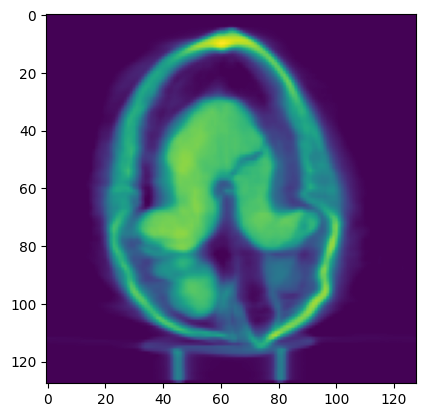

In [12]:
plt.imshow( im_SIRTTV[:, 63, :])

In [13]:
np.save("sirt_au_ag.npy", im_SIRTTV)